## **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.3 MB/s eta 0:00:00


## **Import Libraries**

In [20]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## **Import Dataset**

In [5]:
#dataset import
df = pd.read_csv("/content/drive/MyDrive/Suicide_detection/Suicide_Detection.csv")
df.head(5)

,text,class,age
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,25
1,Am I weird I don't get affected by compliments...,non-suicide,37
2,Finally 2020 is almost over... So I can never ...,non-suicide,30
3,i need helpjust help me im crying so hard,suicide,42
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,20


## **dataset Preprocessing**

In [6]:
#class maping
df['class']=df['class'].apply(lambda x: 1 if x=='suicide' else 0)
df.sample(5)

,text,class,age
169887,Ok but i do want to be cuddling with someone r...,0,47
39395,Done with lifeNothing has ever gone well in my...,1,51
74744,My whole family caught me masturbating on my b...,0,45
230845,I’m scared of dyingBut I still feel like it’s ...,1,32
71454,Fuck you English teacher I had to write an ess...,0,51


In [7]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['class'], stratify=df['class'])

In [8]:
X_train.head(4)

5392      If I commit suicide, will my student loan debt...
130919    Mom doesn't remember me I told my mom that I m...
71348     Anyone care to talk? I can’t sleep. 24, transw...
2054      I cant post my rant It keeps being removed eve...
Name: text, dtype: object

In [9]:
#import bert model
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [10]:
#define embading function
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

## **Model Training**

In [11]:
# model architecture
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [13]:
len(X_train)

174055

In [14]:
#define matrices and model compile
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [16]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
5440/5440 [==============================] - 1850s 340ms/step - loss: 0.2893 - accuracy: 0.8822 - precision: 0.8837 - recall: 0.8802
Epoch 2/3
5440/5440 [==============================] - 1845s 339ms/step - loss: 0.2857 - accuracy: 0.8835 - precision: 0.8852 - recall: 0.8814
Epoch 3/3
5440/5440 [==============================] - 1898s 349ms/step - loss: 0.2839 - accuracy: 0.8837 - precision: 0.8852 - recall: 0.8819


## **Model Evaluations**

In [17]:
#model testing
model.evaluate(X_test, y_test)

1814/1814 [==============================] - 614s 338ms/step - loss: 0.2457 - accuracy: 0.9035 - precision: 0.9027 - recall: 0.9044


[0.24573276937007904,
 0.9034798741340637,
 0.9027041792869568,
 0.9044467210769653]

In [18]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

1814/1814 [==============================] - 628s 346ms/step


In [21]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, ..., 0, 0, 1])

In [22]:
#confusion matrix
cm = confusion_matrix(y_test, y_predicted)
cm

array([[26181,  2828],
       [ 2772, 26238]])

Text(50.722222222222214, 0.5, 'Truth')

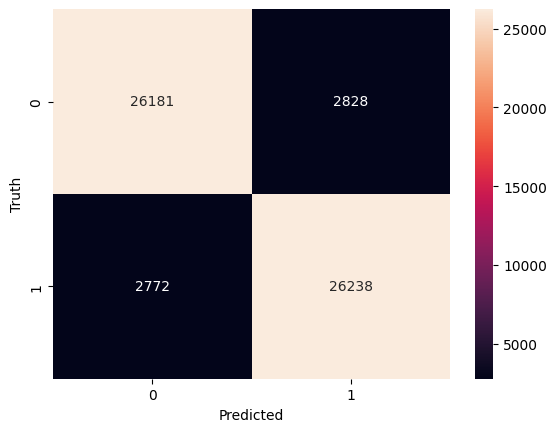

In [23]:
#plot confusion matrix
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
#classification report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     29009
           1       0.90      0.90      0.90     29010

    accuracy                           0.90     58019
   macro avg       0.90      0.90      0.90     58019
weighted avg       0.90      0.90      0.90     58019



## **Model Inference**

In [28]:
Comments = [
    "Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen."
]

In [29]:
pred = model.predict(Comments)

1/1 [==============================] - 0s 40ms/step


In [30]:
threshold = 0.5

result = 1 if pred > threshold else 0
label_map = {0: "non-suicide", 1: "suicide"}
mapped_label = label_map[result]
mapped_label

'suicide'